# Capstone Project: Recommendation System

This project involves building a recommendation system to predict and suggest movies to users based on their preferences. It includes EDA, feature engineering, collaborative filtering, and a deep learning-based model.

## 1. Load Dataset

The dataset contains user ratings for movies. We load the data and inspect its structure.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
ratings_df = pd.read_csv('ratings.csv')

# Convert the timestamp column to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,1999-12-03 19:24:37
1,1,25,1.0,1999-12-03 19:43:48
2,1,29,2.0,1999-11-22 00:36:16
3,1,30,5.0,1999-12-03 19:24:37
4,1,32,5.0,1999-11-22 00:00:58


## 2. Exploratory Data Analysis (EDA)

We explore the dataset to understand the distribution of ratings, user activity, and movie popularity.

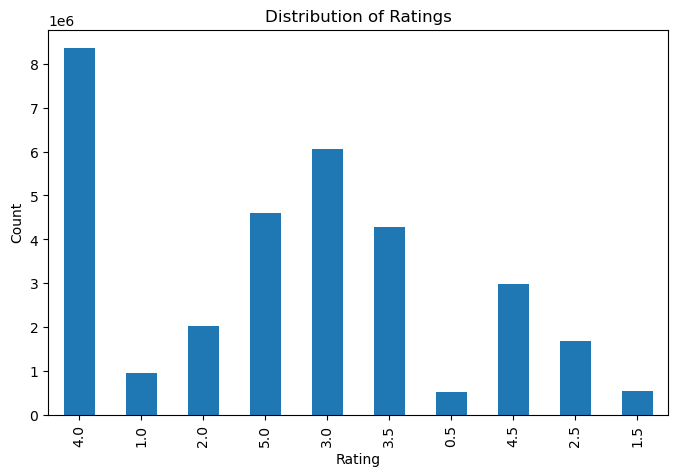

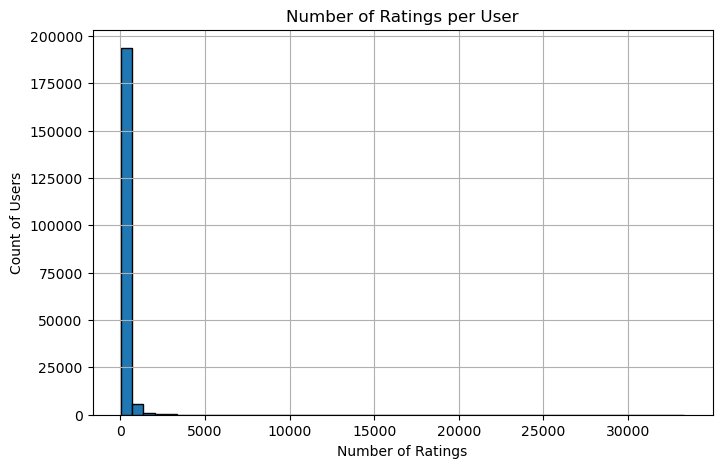

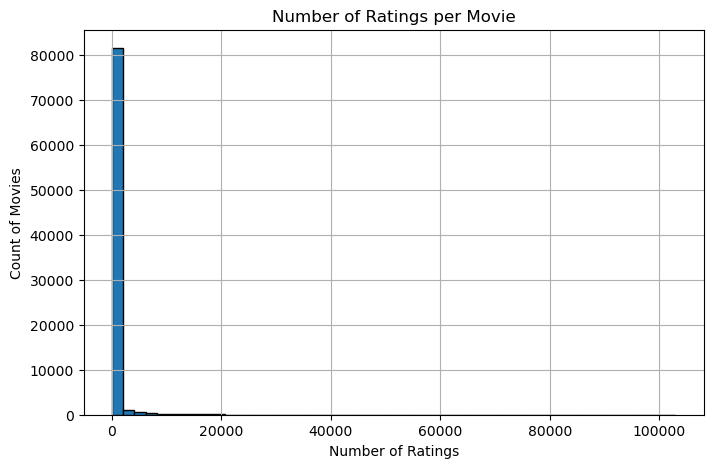

Sparsity of the user-movie matrix: 99.81%


In [6]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
ratings_df['rating'].value_counts(sort=False).plot(kind='bar', title='Distribution of Ratings', xlabel='Rating', ylabel='Count')
plt.show()

# Number of ratings per user
user_ratings_count = ratings_df['userId'].value_counts()
plt.figure(figsize=(8, 5))
user_ratings_count.hist(bins=50, edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

# Number of ratings per movie
movie_ratings_count = ratings_df['movieId'].value_counts()
plt.figure(figsize=(8, 5))
movie_ratings_count.hist(bins=50, edgecolor='black')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()

# Sparsity of the user-movie matrix
num_users = ratings_df['userId'].nunique()
num_movies = ratings_df['movieId'].nunique()
total_possible_interactions = num_users * num_movies
actual_interactions = len(ratings_df)
sparsity = 1 - (actual_interactions / total_possible_interactions)
print(f"Sparsity of the user-movie matrix: {sparsity:.2%}")

## 3. Feature Engineering

We prepare the data for modeling by mapping user and movie IDs to indices.

In [8]:
# Map user and movie IDs to indices
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()
user_id_map = {id_: i for i, id_ in enumerate(user_ids)}
movie_id_map = {id_: i for i, id_ in enumerate(movie_ids)}
ratings_df['user_idx'] = ratings_df['userId'].map(user_id_map)
ratings_df['movie_idx'] = ratings_df['movieId'].map(movie_id_map)

# Split the data into training and testing sets
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

## 4. Baseline Model

The baseline model recommends the top-rated movies to all users.

In [10]:
# Baseline Model: Top-rated movies
baseline_recommendations = ratings_df.groupby('movieId')['rating'].mean().sort_values(ascending=False)
print("Top 10 movies by average rating:")
print(baseline_recommendations.head(10))

Top 10 movies by average rating:
movieId
199103    5.0
268476    5.0
171849    5.0
268054    5.0
268090    5.0
268114    5.0
122649    5.0
225251    5.0
147402    5.0
268438    5.0
Name: rating, dtype: float64


## 5. Collaborative Filtering Model

We implement collaborative filtering using matrix factorization with TensorFlow/Keras.

In [12]:
# Collaborative Filtering Model
embedding_size = 50

# User and Movie Input Layers
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# Embedding Layers
user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
movie_embedding = Embedding(num_movies, embedding_size, input_length=1)(movie_input)

# Flatten the Embeddings
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# Dot Product of User and Movie Vectors
dot_product = Dot(axes=1)([user_vector, movie_vector])

# Model
collab_model = Model(inputs=[user_input, movie_input], outputs=dot_product)
collab_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the Collaborative Filtering Model
collab_history = collab_model.fit(
    [train_data['user_idx'], train_data['movie_idx']],
    train_data['rating'],
    validation_data=([test_data['user_idx'], test_data['movie_idx']], test_data['rating']),
    epochs=5,
    batch_size=64,
    verbose=1
)

C:\Users\bthea\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 39936s 100ms/step - loss: 2.9607 - mae: 1.2374 - val_loss: 0.8309 - val_mae: 0.6955
Epoch 2/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 44236s 111ms/step - loss: 0.6652 - mae: 0.6212 - val_loss: 0.7567 - val_mae: 0.6634
Epoch 4/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 40857s 102ms/step - loss: 0.6234 - mae: 0.6004 - val_loss: 0.7644 - val_mae: 0.6668
Epoch 5/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 41634s 104ms/step - loss: 0.6014 - mae: 0.5888 - val_loss: 0.7701 - val_mae: 0.6680


## 6. Deep Learning-Based Recommendation Model

We enhance the recommendation system with a deep learning-based approach.

In [15]:
# Deep Learning-Based Recommendation Model
# User and Movie Input Layers
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# Embedding Layers
user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
movie_embedding = Embedding(num_movies, embedding_size, input_length=1)(movie_input)

# Flatten the Embeddings
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# Concatenate User and Movie Embeddings
concatenated = Concatenate()([user_vector, movie_vector])

# Fully Connected Layers
fc1 = Dense(128, activation='relu')(concatenated)
fc1 = Dropout(0.5)(fc1)
fc2 = Dense(64, activation='relu')(fc1)
fc2 = Dropout(0.5)(fc2)
output = Dense(1)(fc2)

# Deep Learning Model
deep_model = Model(inputs=[user_input, movie_input], outputs=output)
deep_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the Deep Learning Model
deep_history = deep_model.fit(
    [train_data['user_idx'], train_data['movie_idx']],
    train_data['rating'],
    validation_data=([test_data['user_idx'], test_data['movie_idx']], test_data['rating']),
    epochs=5,
    batch_size=64,
    verbose=1
)

C:\Users\bthea\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 44999s 112ms/step - loss: 0.7235 - mae: 0.6451 - val_loss: 0.6910 - val_mae: 0.6264
Epoch 3/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 45174s 113ms/step - loss: 0.7094 - mae: 0.6377 - val_loss: 0.6862 - val_mae: 0.6289
Epoch 4/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 47609s 119ms/step - loss: 0.7005 - mae: 0.6331 - val_loss: 0.6870 - val_mae: 0.6327
Epoch 5/5
400003/400003 ━━━━━━━━━━━━━━━━━━━━ 46579s 116ms/step - loss: 0.6937 - mae: 0.6296 - val_loss: 0.6910 - val_mae: 0.6312


## 7. Model Evaluation and Comparison

We evaluate the performance of each model and compare the results.

In [17]:
# Evaluate Collaborative Filtering Model
test_loss, test_mae = collab_model.evaluate([test_data['user_idx'], test_data['movie_idx']], test_data['rating'], verbose=0)
print(f"Collaborative Filtering Test Loss: {test_loss}")
print(f"Collaborative Filtering Test MAE: {test_mae}")

# Evaluate Deep Learning Model
deep_test_loss, deep_test_mae = deep_model.evaluate([test_data['user_idx'], test_data['movie_idx']], test_data['rating'], verbose=0)
print(f"Deep Learning Model Test Loss: {deep_test_loss}")
print(f"Deep Learning Model Test MAE: {deep_test_mae}")

# Model Comparison
print("Model Comparison:")
print(f"Baseline Model: Top 10 movies by average rating displayed.")
print(f"Collaborative Filtering: Test Loss = {test_loss}, Test MAE = {test_mae}")
print(f"Deep Learning Model: Test Loss = {deep_test_loss}, Test MAE = {deep_test_mae}")

Collaborative Filtering Test Loss: 0.7701420187950134
Collaborative Filtering Test MAE: 0.6679913997650146
Deep Learning Model Test Loss: 0.6909698843955994
Deep Learning Model Test MAE: 0.6311727166175842
Model Comparison:
Baseline Model: Top 10 movies by average rating displayed.
Collaborative Filtering: Test Loss = 0.7701420187950134, Test MAE = 0.6679913997650146
Deep Learning Model: Test Loss = 0.6909698843955994, Test MAE = 0.6311727166175842
